In [195]:
import numpy as np
import networkx as nx
from networkx import grid_graph
from scipy import linalg
from scipy.special import sici
import math
from matplotlib import pyplot as plt

# Poulson Algorithm 1

In [176]:
def sampling_algorithm_1(K):
    
    n = len(K)
    
    sample = []
    A = K.copy()

    for j in range(n):

        if np.random.rand() < A[j][j]:
            sample.append(j)
        else:
            A[j, j] -= 1

        A[j+1:, j] /= A[j, j]
        A[j+1:, j+1:] -= np.outer(A[j+1:, j], A[j, j+1:])

    return sample, A


# Poulson Algorithm 2

In [177]:
def sampling_algorithm_2():
    
    sample = []
    A = K.copy()

    return sample, A

# Uniform Spanning Trees

C:\Users\samki\AppData\Local\Temp\ipykernel_11004\2504094098.py:9: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.incidence_matrix(G).todense()


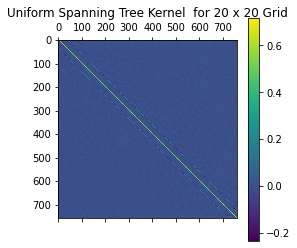

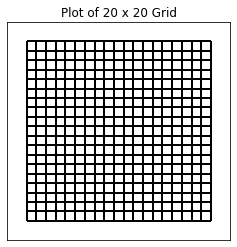

In [183]:
grid_dims = 20

# Create a grid with dimension grid_dims x grid_dims
G = grid_graph(dim=(grid_dims, grid_dims))
pos = {(x,y):(y,-x) for x,y in G.nodes()}
weights = [2 for u,v in G.edges()]

# The vertex-edge incidence matrix
A = nx.incidence_matrix(G).todense()
A_T = A.transpose()
AA_T = A.dot(A_T)

# Compute the kernel K from the vertex-edge incidence matrix 
K = A_T.dot(linalg.inv(AA_T)).dot(A)

plt.matshow(np.array(K))
plt.colorbar()
plt.title("Uniform Spanning Tree Kernel  for %d x %d Grid" % (grid_dims, grid_dims))

plt.figure(3,figsize=(4,4)) 
plt.title("Plot of %d x %d Grid" % (grid_dims, grid_dims))
nx.draw_networkx_edges(
    G,
    pos=pos,
    width=weights,
)
plt.show()

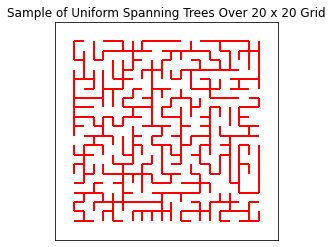

In [185]:
# Sample from the point process

samples,_ = sampling_algorithm_1(K)

plt.figure(3,figsize=(4,4)) 
plt.title("Sample of Uniform Spanning Trees Over %d x %d Grid" % (grid_dims, grid_dims))
nx.draw_networkx_edges(
    G,
    pos=pos,
    width=weights,
    edgelist = [edge for i,edge in enumerate(G.edges()) if i in samples],
    edge_color='red'
)
plt.show()

# Discretized Sine Process

In [204]:
k=4

def compute_sine_kernel_entry(m,l):
    try: 
        upper = sici(1/(2**k)*math.pi*(m-l-1))[0]
    except:
        upper = sici(1/(2**k)*math.pi*(m-l-1))
    
    try:
        lower = sici(1/(2**k)*math.pi*(m-l))[0]
    except:
        lower = sici(1/(2**k)*math.pi*(m-l))
    
    return 1/(-math.pi)*(upper-lower)


sine_K = np.array([[compute_sine_kernel_entry(m,l) for m in range(2**k-1)] for l in range(2**k-1)])
sine_K

array([[0.06236629, 0.06236629, 0.06156773, 0.05998902, 0.05766648,
        0.05465333, 0.05101823, 0.04684346, 0.0422226 , 0.03725808,
        0.03205839, 0.02673517, 0.02140034, 0.01616312, 0.01112726],
       [0.06156773, 0.06236629, 0.06236629, 0.06156773, 0.05998902,
        0.05766648, 0.05465333, 0.05101823, 0.04684346, 0.0422226 ,
        0.03725808, 0.03205839, 0.02673517, 0.02140034, 0.01616312],
       [0.05998902, 0.06156773, 0.06236629, 0.06236629, 0.06156773,
        0.05998902, 0.05766648, 0.05465333, 0.05101823, 0.04684346,
        0.0422226 , 0.03725808, 0.03205839, 0.02673517, 0.02140034],
       [0.05766648, 0.05998902, 0.06156773, 0.06236629, 0.06236629,
        0.06156773, 0.05998902, 0.05766648, 0.05465333, 0.05101823,
        0.04684346, 0.0422226 , 0.03725808, 0.03205839, 0.02673517],
       [0.05465333, 0.05766648, 0.05998902, 0.06156773, 0.06236629,
        0.06236629, 0.06156773, 0.05998902, 0.05766648, 0.05465333,
        0.05101823, 0.04684346, 0.0422226 , 